In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import glob
import dask
import matplotlib
import scipy.special as sps  
import xagg as xa
import pickle

In [2]:
# CA:
casename = 'CA_conus404_asmo_newsurfdata_default.001'
archive_dir = '/glade/derecho/scratch/elkoukah/archive/'
rofdir = archive_dir+casename+'/rof/hist'
dsq_all = xr.open_mfdataset(glob.glob(rofdir+'/*.h.*'))
ds_topology = xr.open_dataset('/glade/work/elkoukah/empirical/optimize/opt_camels/routing/ancillary_data/topology_CA.nc')
qmean = dsq_all['IRFroutedRunoff'].mean('time').compute()
qmean = qmean.assign_coords({'seg':ds_topology['segId']})

ifile = '/glade/work/elkoukah/empirical/production/mizuroute/ancillary_data/river_CA.gpkg'
shp_river = gpd.read_file(ifile)

# Shapefiles
shp_ca = shp_river.set_index('COMID')
shp_ca = shp_ca.reindex(qmean.seg.values)
shp_ca['IRFroutedRunoff'] = qmean.data
shp_ca = shp_ca.sort_values(by='IRFroutedRunoff')

shapfile = '/glade/work/elkoukah/inputs/domain/shapefile/wbd_SWUS_epsg4326.shp'
gdf = gpd.read_file(shapfile)
ca_gdf = [gdf[gdf['huc4']==huc4] for huc4 in gdf['huc4'] if huc4.startswith('18')]
ca_gdf = pd.concat(ca_gdf)

ca_gdf_crs = ca_gdf.to_crs(ccrs.PlateCarree())
shp_ca_crs = shp_ca.to_crs(ccrs.PlateCarree())

In [3]:
# CR:
# casename = 'CR_conus404_asmo_newsurfdata_fanrootingdepth.002'
casename = 'CR_conus404_newsurfdata_default.002'
archive_dir = '/glade/derecho/scratch/elkoukah/archive/'
rofdir = archive_dir+casename+'/rof/hist'
dsq_all = xr.open_mfdataset(glob.glob(rofdir+'/*.h.*'))
ds_topology = xr.open_dataset('/glade/work/elkoukah/empirical/production/mizuroute//ancillary_data/topology_77032202.nc')
qmean = dsq_all['IRFroutedRunoff'].mean('time').compute()
qmean = qmean.assign_coords({'seg':ds_topology['segId']})

ifile = '/glade/work/elkoukah/empirical/production/mizuroute/ancillary_data/river_77032202.gpkg'
shp_river = gpd.read_file(ifile)

# Shapefiles
shp_cr = shp_river.set_index('COMID')
shp_cr = shp_cr.reindex(qmean.seg.values)
shp_cr['IRFroutedRunoff'] = qmean.data
shp_cr = shp_cr.sort_values(by='IRFroutedRunoff')

shapfile = '/glade/work/elkoukah/inputs/domain/shapefile/wbd_SWUS_epsg4326.shp'
gdf = gpd.read_file(shapfile)
cr_gdf = [gdf[gdf['huc4']==huc4] for huc4 in gdf['huc4'] if huc4.startswith('14') or huc4.startswith('15')]
cr_gdf = pd.concat(cr_gdf)

cr_gdf_crs = cr_gdf.to_crs(ccrs.PlateCarree())
shp_cr_crs = shp_cr.to_crs(ccrs.PlateCarree())

In [4]:
# River settings
linewidth_cr = np.maximum(np.log10(shp_cr_crs['IRFroutedRunoff'])-.6,0)
linewidth_ca = np.maximum(np.log10(shp_ca_crs['IRFroutedRunoff'])-.6,0)
river_col = 'Blues'
river_ttl = '(c) Mean simulated streamflow'
river_lbl = '$[m^3~s^{-1}]$'
river_min = 1e-1
river_max = .5e3
river_nrm = matplotlib.colors.LogNorm(vmin=river_min, vmax=river_max)

In [5]:
shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_14_HU2_Shape/WBDHU2.shp'
gdf_ucrb = gpd.read_file(shapefile)
gdf_ucrb_crs = gdf_ucrb.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_15_HU2_Shape/WBDHU2.shp'
gdf_lcrb = gpd.read_file(shapefile)
gdf_lcrb_crs = gdf_lcrb.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/WBD_18_HU2_Shape/WBDHU2.shp'
gdf_ca = gpd.read_file(shapefile)
gdf_ca_crs = gdf_ca.to_crs(ccrs.PlateCarree())

shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/SWUS_studydomain_epsg4326.shp'
gdf_sw = gpd.read_file(shapefile)
gdf_sw_crs = gdf_sw.to_crs(ccrs.PlateCarree())

In [6]:
# drop camels from CA
comids_ca = pd.read_csv('/glade/work/elkoukah/inputs/obs/CDEC_Stations_COMID.csv')
comids_ca = comids_ca.set_index('STA')
comids_ca = comids_ca.drop('CLD')
cdec_stations = comids_ca.index.values

ca_opt_metrics = pd.read_csv('./out/metrics_opt_ca_camels_101980-092020.csv', index_col=0)
ca_opt_metrics = ca_opt_metrics.loc[ca_opt_metrics.index.isin(cdec_stations)]
cr_opt_metrics = pd.read_csv('./out/metrics_opt_cr_101980-092020.csv', index_col=0)
metrics_southwest_opt = pd.concat([cr_opt_metrics, ca_opt_metrics])

ca_base_metrics = pd.read_csv('./out/metrics_base_ca_camels_101980-092020.csv', index_col=0)
ca_base_metrics = ca_base_metrics.loc[ca_base_metrics.index.isin(cdec_stations)]
cr_base_metrics = pd.read_csv('./out/metrics_base_cr_101980-092019.csv', index_col=0)
metrics_southwest_base = pd.concat([cr_base_metrics, ca_base_metrics])

In [7]:
cbar_ticks = {'mkge':np.arange(0., .91, .2),
              'sigma':np.array([0.5 , 0.75, 0.85, 1.15, 1.25, 1.5 ]),
              'beta':np.array([-0.5 , -0.25, -0.1, 0.1, 0.25, 0.5]),
              'r2':np.arange(0., .91, .2),}
labels = {'mkge':r"KGE$^{''}$",
          # 'mkge':r"modified Kling–Gupta efficiency (KGE$^{''}$)",
          'r2':'$r$',
          'sigma':r'$\alpha$',
          'beta':r'$\beta$',
         }
extent = (-124.6, -105.6, 30.02, 43.46)
df1, df2 = metrics_southwest_base, metrics_southwest_opt
metric = 'mkge'
cmap = 'RdBu' #'PiYG'
norm = matplotlib.colors.BoundaryNorm(boundaries=cbar_ticks[metric], ncolors=256, extend='both')
ticks = cbar_ticks[metric]
label = labels[metric]

In [8]:
# station used in optimization
camels_ucrb = ['9034900', '9035800', '9035900', '9047700', '9065500', '9066000', '9066200', '9066300', '9081600', '9107000', '9210500', '9223000', '9306242', '9312600', '9352900', '9378170', '9378630']
reclamation_ucrb = ['9379500', '9355500', '9306500', '9260000', '9251000', '9234500', '9217000', '9211200', '9180000', '9152500', '9127800', '9124700', '9109000', '9095500', '9072500']
sac_ca = ['AMA', 'AMF', 'AMK', 'AMN', 'ANT', 'ASV', 'DAV', 'FPL', 
          'FPR', 'FRD', 'FTC', 'FTM', 'FTO', 'FTP', 'MSS', 'PLK',
          'PSH', 'SBB', 'SCU', 'SDT', 'SIS', 'SMU', 'SQS', 'SVC', 
          'YBG', 'YBJ', 'YBM', 'YBS', 'YCB', 'YRS']

In [9]:
ma1 = metrics_southwest_base.index.isin([float(i) for i in camels_ucrb])*False
ma2 = metrics_southwest_base.index.isin([float(i) for i in reclamation_ucrb])
ma3 = metrics_southwest_base.index.isin(sac_ca)
st_used_in_opt = (ma1+ma2+ma3)

In [54]:
# River settings
linewidth_cr = np.maximum(np.log10(shp_cr_crs['IRFroutedRunoff'])-.8,0)
linewidth_ca = np.maximum(np.log10(shp_ca_crs['IRFroutedRunoff'])-.8,0)
river_col = 'Blues'
river_ttl = '(c) Mean simulated streamflow'
river_lbl = '$[m^3~s^{-1}]$'
river_min = 1e-1
river_max = .5e3
river_nrm = matplotlib.colors.LogNorm(vmin=river_min, vmax=river_max)

In [11]:
shapefile = '/glade/work/elkoukah/inputs/domain/shapefile/wbd_SWUS_epsg4326.shp'
gdf_wbd = gpd.read_file(shapefile)
gdf_wbd_crs = gdf_wbd.to_crs(ccrs.PlateCarree())

In [12]:
# DEM
demfile = '/glade/work/elkoukah/inputs/obs/topo/gtopo30_h1kna/epsg4326_na_dem.nc'
dem = xr.open_dataset(demfile)['Band1']
dem_sw = dem.sel(lat=slice(30,45), lon=slice(-125,-105))
dem_sw = dem_sw.where(dem_sw<=4401)

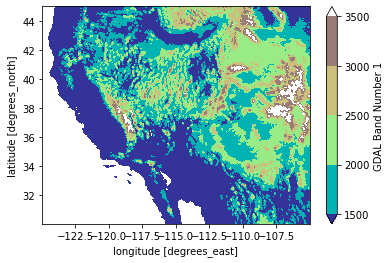

In [13]:
dem_sw.plot.contourf(levels=[1500, 2000, 2500, 3000, 3500], cmap='terrain')

In [14]:
from matplotlib.colors import LightSource

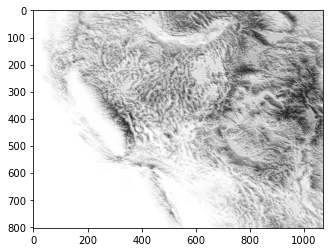

In [15]:
fig = plt.figure()
z = dem_sw.fillna(0).data
ls = LightSource(azdeg=159-180, altdeg=30)
# cmap = plt.cm.gist_earth
cmap = plt.cm.Greys
rgb = ls.shade(z, cmap=cmap, blend_mode='soft', vert_exag=0.1, dx=1, dy=1)
# ma = (rgb==0.).any(axis=-1)
# rgb[ma] = 1.
plt.imshow(np.ma.masked_greater(rgb, 0.)[::-1])

In [34]:
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 200))
cut_terrain_map = matplotlib.colors.LinearSegmentedColormap.from_list('cut_terrain', colors_land)

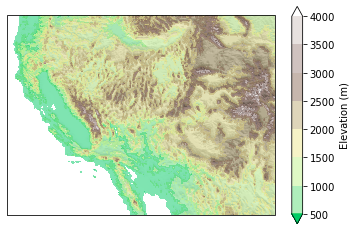

In [75]:
fig = plt.figure()
ax = plt.subplot(111, projection=ccrs.PlateCarree())
dem_extent = (dem_sw.lon[0], dem_sw.lon[-1], dem_sw.lat[0], dem_sw.lat[-1])
ax.imshow(rgb[::-1], extent=dem_extent, alpha=1)

z2 = dem_sw.where(dem_sw>0)
z2.attrs['long_name'] = 'Elevation (m)'
z2.plot.contourf(ax=ax, levels=np.arange(500, 4500, 500), cmap=cut_terrain_map, alpha=.5)

In [120]:
from matplotlib.patches import Patch
import matplotlib.lines as mlines

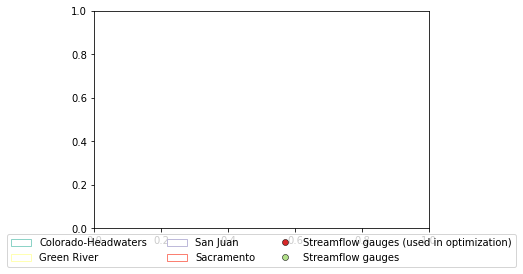

In [121]:
fig, ax = plt.subplots()
labels = ['Colorado-Headwaters', 'Green River', 'San Juan', 'Sacramento']
colors = ['#8dd3c7', '#ffffb3',  '#bebada', '#fb8072']
handles = [
    Patch(facecolor='None', edgecolor=color, label=label) 
    for label, color in zip(labels, colors)
]
handles += [mlines.Line2D([], [], color='tab:red', marker='o', markeredgecolor='k', markeredgewidth=.5, linestyle='None',label='Streamflow gauges (used in optimization)'),
            mlines.Line2D([], [], color='#b2df8a', marker='o', markeredgecolor='k', markeredgewidth=.5, linestyle='None', label='Streamflow gauges')]
ax.legend(handles=handles, loc='lower center', ncol=3, bbox_to_anchor=(.5,-.2))

In [122]:
# Map of reservoirs

610 Hoover
597 Glen Canyon
451 Flaming Gorge
601 Navajo
132 Shasta
148 Oroville
131 Trinity
198 New Melones


[None, None, None, None]

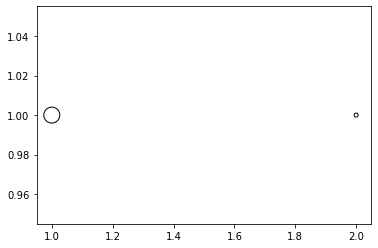

In [123]:
camadir = "/glade/work/elkoukah/empirical/reservoirs/cama400/"
daminfo_file = camadir + "my_dams_setup/pxpy_qmax_my_dam_list.xlsx"
daminfo_cr = pd.read_excel(daminfo_file, index_col="ID")
daminfo_cr['huc2'] = 'CR'
daminfo_file = camadir + "my_dams_setup/pxpy_qmax_my_dam_list_ca.xlsx"
daminfo_ca = pd.read_excel(daminfo_file, index_col="ID")
daminfo_ca['huc2'] = 'CA'
daminfo = pd.concat([daminfo_cr, daminfo_ca])

ma = daminfo['Purpose']=='HPD'
# ma1 = daminfo['Purpose']=='MPD'
size = np.maximum(np.log10(daminfo['Total storage (FSL, Mm3)']),0)**4

# sel_damids = [610,597,451,541,601,
#                132,148,131,198,210]

sel_damids = [610,597,451,601,
               132,148,131,198]

daminfo.loc[sel_damids]
for i, row in daminfo.loc[sel_damids].iterrows():
    print(i, row['Project name'])

fig = plt.figure()
ax = plt.subplot(111)
s = [np.log10(10**10/10**6)**4, np.log10(10**8/10**6)**4]
l = [r'10$^{10}$ m$^3$', r'10$^{8}$ m$^3$'][::-1]
sc = ax.scatter([1,2], [1,1], s=s, c='None', edgecolor='k', lw=1, label=l)
hs = sc.legend_elements("sizes", num=4)[0]
[h.set_color('grey') for h in hs]
[h.set_markeredgecolor('k') for h in hs]

In [124]:
import matplotlib.gridspec as gridspec

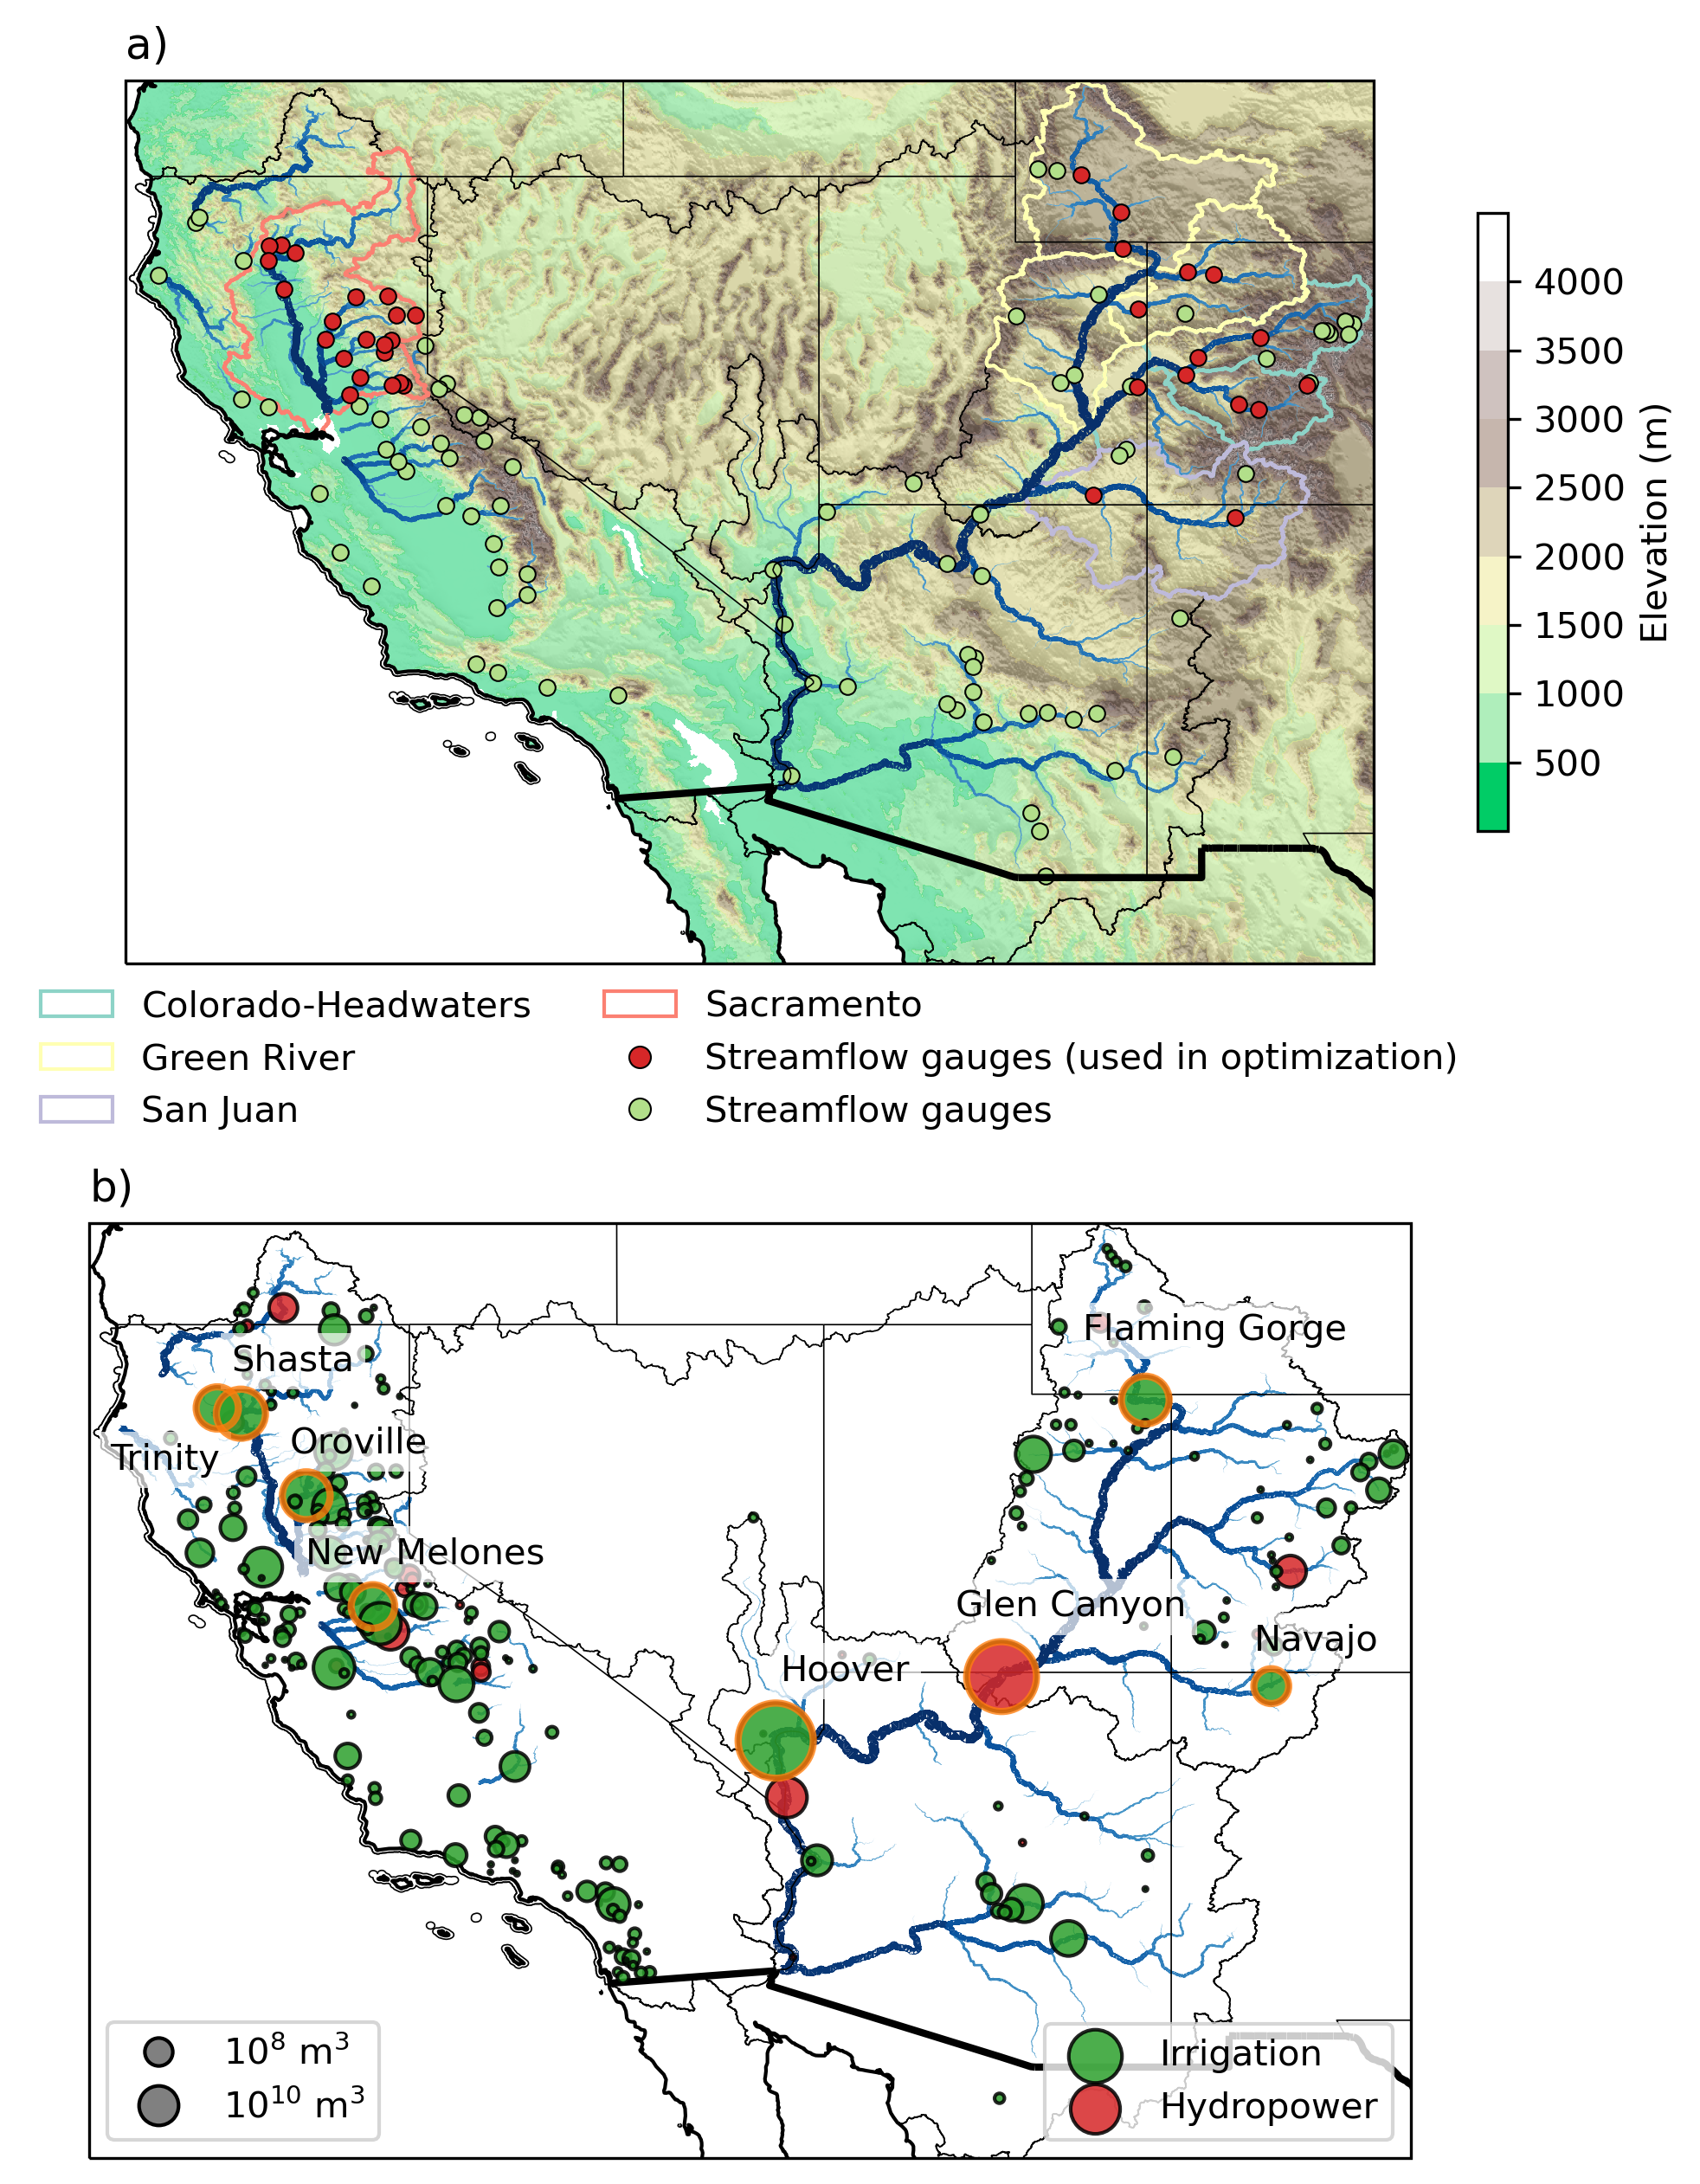

In [129]:
fig = plt.figure(figsize=(8,8), dpi=300)
gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.,right=1.,top=1.,bottom=.575,wspace=0.1,hspace=0.25)
ax = plt.subplot(gs1[0,0],projection=ccrs.PlateCarree())
ax.set_title('a)', loc='left')

dem_extent = (dem_sw.lon[0], dem_sw.lon[-1], dem_sw.lat[0], dem_sw.lat[-1])
ax.imshow(rgb[::-1], extent=dem_extent, alpha=1)
z2.plot.contourf(ax=ax, levels=np.arange(500, 4500, 500), cmap=cut_terrain_map, alpha=.5, cbar_kwargs={'shrink':.7, 'extendrect':True, 'extendfrac':'auto'})

states_provinces = cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces_lines',
                                                scale='50m',
                                                facecolor='none')
ax.add_feature(states_provinces, edgecolor='k', lw=.4)
ax.add_feature(cfeature.BORDERS, edgecolor='k', lw=2)
ax.add_feature(cfeature.COASTLINE, edgecolor='k', lw=1)
gdf_ucrb_crs.plot(ax=ax, lw=0.4, facecolor='None', edgecolor='k', )
gdf_lcrb_crs.plot(ax=ax, lw=0.4, facecolor='None', edgecolor='k',)
gdf_ca_crs.plot(ax=ax, lw=0.4, facecolor='None', edgecolor='k', )
gdf_sw_crs.plot(ax=ax, lw=.4, facecolor='None', edgecolor='k')
ax.set_extent(extent)

opt_huc4 = ['1401','1402','1403',  '1404','1405','1406',  '1408',   '1802']
colors = ['#8dd3c7','#8dd3c7','#8dd3c7',  '#ffffb3','#ffffb3','#ffffb3',  '#bebada', '#fb8072']
for i, huc4 in enumerate(opt_huc4):
    gdfi = gdf_wbd_crs[gdf_wbd_crs['huc4']==huc4]
    gdfi.plot(ax=ax, lw=1, edgecolor=colors[i], facecolor='None', alpha=1)

shp_ca_crs.plot(ax=ax, column='IRFroutedRunoff', linewidth=linewidth_ca, 
             cmap=river_col, vmin=river_min, vmax=river_max, norm=river_nrm, zorder=1,)
shp_cr_crs.plot(ax=ax, column='IRFroutedRunoff', linewidth=linewidth_cr, 
             cmap=river_col, vmin=river_min, vmax=river_max, norm=river_nrm, zorder=1,)

metrics_southwest_base[~st_used_in_opt].plot.scatter(x='lon', y='lat', ax=ax, c='#b2df8a', edgecolor='k', lw=.5)
metrics_southwest_base[st_used_in_opt].plot.scatter(x='lon', y='lat', ax=ax, c='tab:red', edgecolor='k', lw=.5)
ax.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(.5,-.225), frameon=False)

# reservoirs
gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.,right=1.,top=.45,bottom=0.,wspace=0.1,hspace=0.25)
ax = plt.subplot(gs2[0,0],projection=ccrs.PlateCarree())
ax.set_title('b)', loc='left')

ax.add_feature(states_provinces, edgecolor='k', lw=.4)
ax.add_feature(cfeature.BORDERS, edgecolor='k', lw=2)
ax.add_feature(cfeature.COASTLINE, edgecolor='k', lw=1)
gdf_ucrb_crs.plot(ax=ax, lw=0.4, facecolor='None', edgecolor='k', )
gdf_lcrb_crs.plot(ax=ax, lw=0.4, facecolor='None', edgecolor='k',)
gdf_ca_crs.plot(ax=ax, lw=0.4, facecolor='None', edgecolor='k', )
gdf_sw_crs.plot(ax=ax, lw=.4, facecolor='None', edgecolor='k')
ax.set_extent(extent)
shp_ca_crs.plot(ax=ax, column='IRFroutedRunoff', linewidth=linewidth_ca, 
             cmap=river_col, vmin=river_min, vmax=river_max, norm=river_nrm, zorder=1,)
shp_cr_crs.plot(ax=ax, column='IRFroutedRunoff', linewidth=linewidth_cr, 
             cmap=river_col, vmin=river_min, vmax=river_max, norm=river_nrm, zorder=1,)

sc = ax.scatter(daminfo['Lon'][~ma], daminfo['Lat'][~ma], c='tab:green', s=size[~ma], alpha=.85, edgecolor='k', lw=1, zorder=3, label='Irrigation')
ax.scatter(daminfo['Lon'][ma], daminfo['Lat'][ma], c='tab:red', s=size[ma], alpha=.85, edgecolor='k', lw=1, zorder=2, label='Hydropower')

# First legend
first_legend = ax.legend(handles=hs, labels=l, loc='lower left', frameon=True)
ax.add_artist(first_legend)
# Second legend
plt.legend(scatterpoints=1, frameon=True, loc='lower right', ncol=1)

ax.scatter(daminfo.loc[sel_damids]['Lon'], daminfo.loc[sel_damids]['Lat'], c='None', s=size.loc[sel_damids], alpha=.8, edgecolor='tab:orange', ls='-', lw=2, zorder=4)
offsets = [1,1,1,.65,.75,.75,-.75,.75]
for i, row in daminfo.loc[sel_damids].iterrows():
    x1,y1 = row['Lon'], row['Lat']
    ii = sel_damids.index(i)
    x2,y2 = x1+offsets[ii], y1+offsets[ii]
    ax.annotate(row['Project name'], color='k',
            xy=(x1, y1), xycoords='data',
            xytext=(x2, y2), textcoords='data',
            ha="center", va="center",
            bbox=dict(boxstyle="square", fc="w", edgecolor="None", alpha=.7), zorder=3)

In [130]:
fig.savefig('figs/studydomain_map_v01.png', dpi=300, bbox_inches='tight')

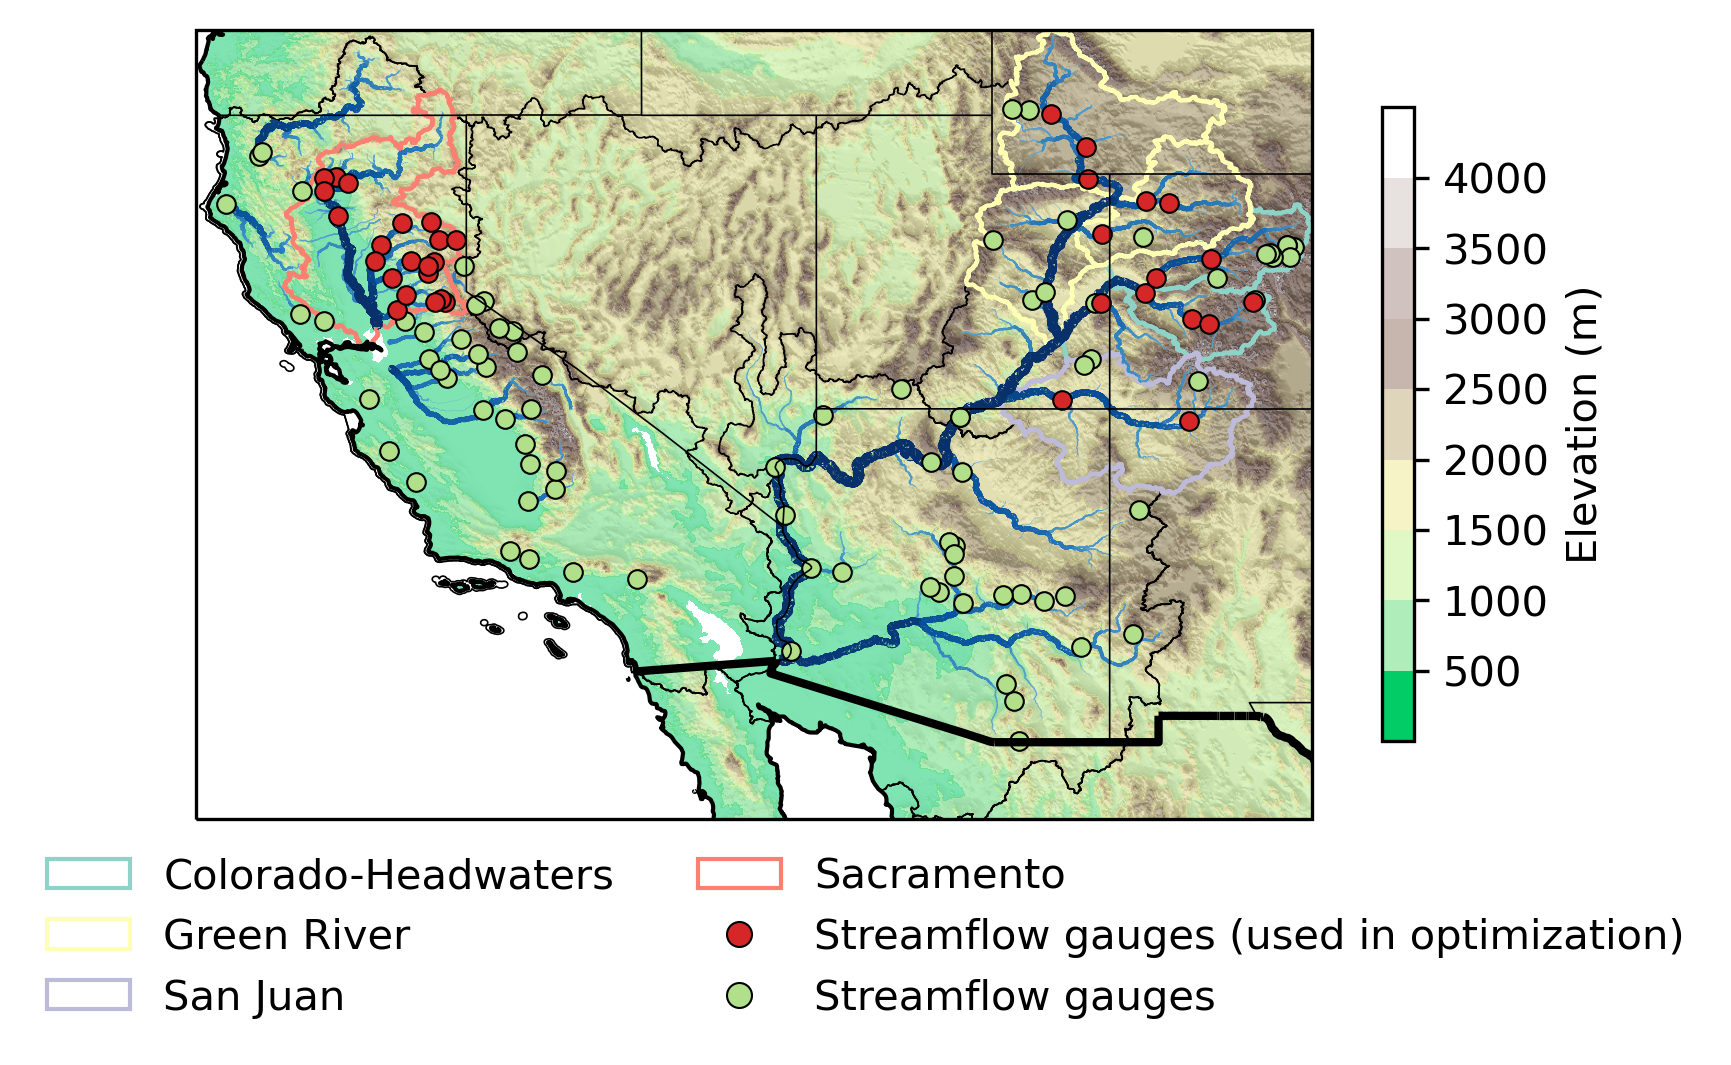

In [88]:
fig = plt.figure(dpi=300)
axes = []
ax = plt.subplot(111, projection=ccrs.PlateCarree())
axes += [ax]

dem_extent = (dem_sw.lon[0], dem_sw.lon[-1], dem_sw.lat[0], dem_sw.lat[-1])
ax.imshow(rgb[::-1], extent=dem_extent, alpha=1)
z2.plot.contourf(ax=ax, levels=np.arange(500, 4500, 500), cmap=cut_terrain_map, alpha=.5, cbar_kwargs={'shrink':.7, 'extendrect':True, 'extendfrac':'auto'})

states_provinces = cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces_lines',
                                                scale='50m',
                                                facecolor='none')
ax.add_feature(states_provinces, edgecolor='k', lw=.4)
ax.add_feature(cfeature.BORDERS, edgecolor='k', lw=2)
# ax.add_feature(cfeature.RIVERS, edgecolor='grey', lw=.4, zorder=-1)
# ax.add_feature(cfeature.LAKES, edgecolor='grey', lw=.1)
ax.add_feature(cfeature.COASTLINE, edgecolor='k', lw=1)
gdf_ucrb_crs.plot(ax=ax, lw=0.4, facecolor='None', edgecolor='k', )
gdf_lcrb_crs.plot(ax=ax, lw=0.4, facecolor='None', edgecolor='k',)
gdf_ca_crs.plot(ax=ax, lw=0.4, facecolor='None', edgecolor='k', )
gdf_sw_crs.plot(ax=ax, lw=.4, facecolor='None', edgecolor='k')
ax.set_extent(extent)

opt_huc4 = ['1401','1402','1403',  '1404','1405','1406',  '1408',   '1802']
colors = ['#8dd3c7','#8dd3c7','#8dd3c7',  '#ffffb3','#ffffb3','#ffffb3',  '#bebada', '#fb8072']
for i, huc4 in enumerate(opt_huc4):
    gdfi = gdf_wbd_crs[gdf_wbd_crs['huc4']==huc4]
    gdfi.plot(ax=ax, lw=1, edgecolor=colors[i], facecolor='None', alpha=1)

shp_ca_crs.plot(ax=ax, column='IRFroutedRunoff', linewidth=linewidth_ca, 
             cmap=river_col, vmin=river_min, vmax=river_max, norm=river_nrm, zorder=1,)
shp_cr_crs.plot(ax=ax, column='IRFroutedRunoff', linewidth=linewidth_cr, 
             cmap=river_col, vmin=river_min, vmax=river_max, norm=river_nrm, zorder=1,)

metrics_southwest_base[~st_used_in_opt].plot.scatter(x='lon', y='lat', ax=ax, c='#b2df8a', edgecolor='k', lw=.5)
metrics_southwest_base[st_used_in_opt].plot.scatter(x='lon', y='lat', ax=ax, c='tab:red', edgecolor='k', lw=.5)
ax.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(.6,-.3), frameon=False)

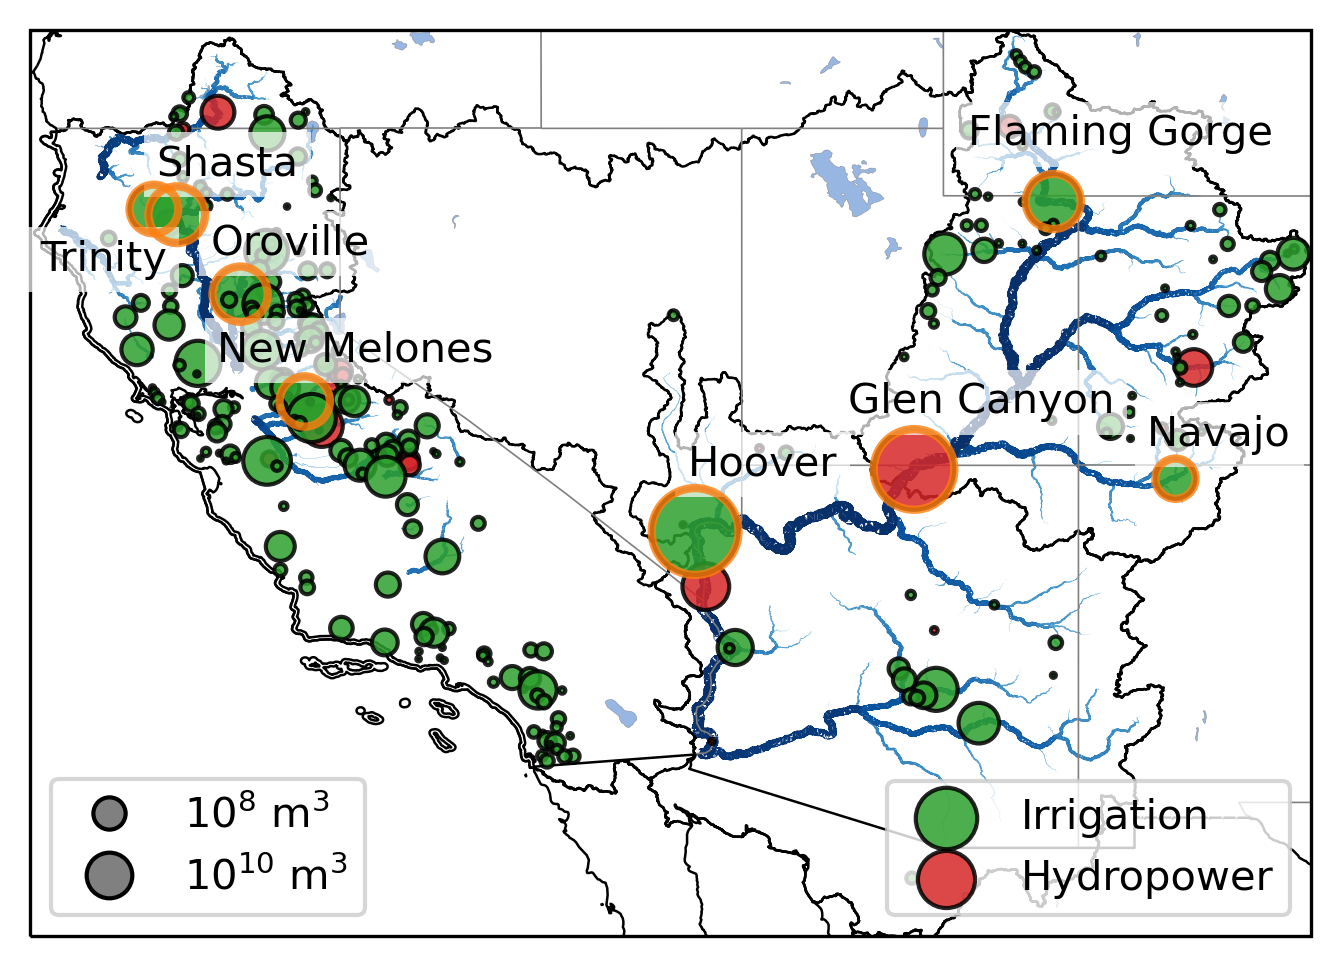

In [117]:
fig = plt.figure(dpi=300)
axes = []
ax = plt.subplot(111, projection=ccrs.PlateCarree())
axes += [ax]
states_provinces = cfeature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces_lines',
                                                scale='50m',
                                                facecolor='none')
ax.add_feature(states_provinces, edgecolor='grey', lw=.4)
ax.add_feature(cfeature.BORDERS, edgecolor='k', lw=.6)
# ax.add_feature(cfeature.RIVERS, edgecolor='grey', lw=.4, zorder=-1)
ax.add_feature(cfeature.LAKES, edgecolor='grey', lw=.1, zorder=-1)
ax.add_feature(cfeature.COASTLINE, edgecolor='k', lw=.6)
gdf_ucrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
gdf_lcrb_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
gdf_ca_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
gdf_sw_crs.plot(ax=ax, lw=0.6, facecolor='None', edgecolor='k')
ax.set_extent(extent)
shp_ca_crs.plot(ax=ax, column='IRFroutedRunoff', linewidth=linewidth_ca, 
             cmap=river_col, vmin=river_min, vmax=river_max, norm=river_nrm, zorder=1,)
shp_cr_crs.plot(ax=ax, column='IRFroutedRunoff', linewidth=linewidth_cr, 
             cmap=river_col, vmin=river_min, vmax=river_max, norm=river_nrm, zorder=1,)

sc = ax.scatter(daminfo['Lon'][~ma], daminfo['Lat'][~ma], c='tab:green', s=size[~ma], alpha=.85, edgecolor='k', lw=1, zorder=3, label='Irrigation')
ax.scatter(daminfo['Lon'][ma], daminfo['Lat'][ma], c='tab:red', s=size[ma], alpha=.85, edgecolor='k', lw=1, zorder=2, label='Hydropower')

# Create a legend for the first line.
first_legend = ax.legend(handles=hs, labels=l, loc='lower left', frameon=True)
ax.add_artist(first_legend)

# second legend
plt.legend(scatterpoints=1, frameon=True, loc='lower right', ncol=1)
# h1,l1 = ax.get_legend_handles_labels()
# plt.legend(handles+h1, l+l1, frameon=True, loc='lower left', ncol=3)
# metrics_southwest_base[~st_used_in_opt].plot.scatter(x='lon', y='lat', ax=ax, c='#b2df8a', edgecolor='k', lw=.5)
# metrics_southwest_base[st_used_in_opt].plot.scatter(x='lon', y='lat', ax=ax, c='tab:red', edgecolor='k', lw=.5)
# ax.legend(handles=handles, loc='lower center', ncol=3, bbox_to_anchor=(.5,-.2))
# offsets = [1,1,1,1,.75,.75,-.75,.75,1,-.5]

ax.scatter(daminfo.loc[sel_damids]['Lon'], daminfo.loc[sel_damids]['Lat'], c='None', s=size.loc[sel_damids], alpha=.8, edgecolor='tab:orange', ls='-', lw=2, zorder=4)
offsets = [1,1,1,.65,.75,.75,-.75,.75]
for i, row in daminfo.loc[sel_damids].iterrows():
    x1,y1 = row['Lon'], row['Lat']
    ii = sel_damids.index(i)
    x2,y2 = x1+offsets[ii], y1+offsets[ii]
    ax.annotate(row['Project name'], color='k',
            xy=(x1, y1), xycoords='data',
            xytext=(x2, y2), textcoords='data',
            ha="center", va="center",
            bbox=dict(boxstyle="square", fc="w", edgecolor="None", alpha=.7), zorder=3)
            # arrowprops=dict(arrowstyle="-"))
    # if i==451: break